# Documentación del Dataset – Clasificación de Flexiones por Técnica

## 1. Introducción al problema

La correcta ejecución de los ejercicios de fuerza —especialmente los ejercicios de autocarga como las flexiones— es fundamental para evitar lesiones y garantizar un entrenamiento eficaz. Sin embargo, muchas personas sin experiencia previa desconocen si están realizando el movimiento con una técnica adecuada.

Este proyecto aborda el siguiente problema:

**¿Es posible clasificar vídeos de flexiones en función de si la técnica de ejecución es buena o mala?**

El objetivo final es desarrollar un sistema inteligente capaz de analizar vídeos de personas realizando flexiones y determinar si la postura corporal es correcta. Esto tendría aplicaciones directas en sistemas de asistencia deportiva, plataformas de entrenamiento remoto y herramientas educativas para principiantes.

---

## 2. Obtención y procesamiento del conjunto de datos

### 2.1. Origen de los datos

Hemos obtenido el dataset con los vídeos de la página: https://www.kaggle.com/datasets/mohamadashrafsalama/pushup/data.  
En ellos, varias personas realizan flexiones de dos tipos:

- **Flexiones con técnica correcta**  
- **Flexiones con técnica incorrecta**  
  (por ejemplo: codos demasiado abiertos, cadera hundida, rango de movimiento insuficiente, etc.)

Cada vídeo se etiqueta manualmente según la calidad de ejecución de la flexión.

### 2.2. Preprocesamiento con MediaPipe Pose

Para evitar trabajar directamente con frames completos (lo que implicaría un coste computacional elevado), se aplica un preprocesamiento basado en **MediaPipe Pose**, una librería de visión por computador que identifica automáticamente 33 puntos clave del cuerpo (*landmarks*) en cada frame del vídeo.

Para cada frame se extraen:

- Coordenada **x**
- Coordenada **y**

de cada punto clave relevante.

Esto produce un array NumPy por vídeo con la forma (num_frames, 66), donde 66 corresponde a **33 puntos × 2 coordenadas**.

### 2.3. Cálculo de ángulos articulares

A partir de los landmarks se calcula, para cada frame, un conjunto de **ángulos articulares determinantes**, como por ejemplo:

- Ángulo del codo (izquierdo y derecho)
- Ángulo de la rodilla (izquierdo y derecho)
- Ángulo de la cadera respecto al tronco
- Ángulos relacionados con la posición del torso

Esto genera el dataset final, con cada frame representado por un array de $n_{\text{frames}} \times 8$
, donde cada fila contiene los **8 ángulos** calculados para un frame.

Este formato es mucho más manejable y captura la postura corporal de forma eficaz para el posterior modelado.

---

## 3. Tarea y uso previsto de los datos

El dataset se utilizará para entrenar un modelo de *deep learning* secuencial basado en **redes LSTM**, capaz de analizar la evolución temporal de los ángulos articulares durante la ejecución del ejercicio.

El objetivo de la red es clasificar cada secuencia (cada vídeo) como:

- **Flexión bien ejecutada**
- **Flexión mal ejecutada**

La tarea es, por tanto, un problema de **clasificación binaria sobre datos temporales**.



# Librerías

In [58]:
import sys
sys.path.append("../src")
from utils import extract_xy_sequence, extract_frame_from_video, draw_landmarks_on_frame

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Extracción de los puntos clave de los vídeos
Utilizamos la librería Media Pipe para la extracción de las coordenadas de los puntos clave del cuerpo en el vídeo. En el fichero utils.py, tenemos algunas funciones necesarias para la extracción de los landmarks. 

El propósito de este proyecto no se centra en la predicción de las coordenadas de los landmarks, sino en analizar como la posición de éstos evoluciona en el vídeo para determinar si la flexión está bien hecha o no. 

In [2]:
# Ejemplo de uso
data_path = "../data"
correct_push_ups_path = os.path.join(data_path, "Correct sequence")
wrong_push_ups_path = os.path.join(data_path, "Wrong sequence")
example_video_path = os.path.join(correct_push_ups_path, "Copy of push up 1.mp4")
seq = extract_xy_sequence(example_video_path)
print("Forma de la secuencia de landmarks", seq.shape)    # → (num_frames, 33, 2)
print("Tipo de datos de la secuencia de landmarks", type(seq))          # array con las coordenadas (x,y) de los 33 landmarks por frame


Forma de la secuencia de landmarks (61, 66)
Tipo de datos de la secuencia de landmarks <class 'numpy.ndarray'>


(-0.5, 639.5, 359.5, -0.5)

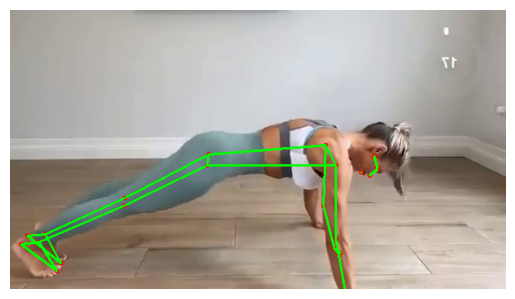

In [3]:
import matplotlib.pyplot as plt
import os

# Ejemplo de uso (comentado):
# frame = cv2.imread('ruta_a_imagen.jpg')  # BGR

# Extraemos un frame del vídeo
path_video = os.path.join(data_path, "Correct sequence", "Copy of push up 1.mp4")
frame10 = extract_frame_from_video(path_video, frame_idx=10)

# Nos quedamos con los landmarks del frame 10
lm = seq[10]  # si seq tiene shape (num_frames, 66) o (num_frames, 33, 2)

# Dibujamos los landmarks sobre el frame
draw_landmarks_on_frame(frame10, lm)
plt.imshow(cv2.cvtColor(frame10, cv2.COLOR_BGR2RGB))
plt.axis('off')

frame10 = extract_frame_from_video(path_video, frame_idx=10)

# Nos quedamos con los landmarks del frame 10
lm = seq[10]  # si seq tiene shape (num_frames, 66) o (num_frames, 33, 2)

# Dibujamos los landmarks sobre el frame
draw_landmarks_on_frame(frame10, lm)
plt.imshow(cv2.cvtColor(frame10, cv2.COLOR_BGR2RGB))
plt.axis('off')


In [4]:
# Probamos a añadir padding a la secuencia de ejemplo
PADDING_LENGTH = 150  # longitud máxima de secuencia (frames)

padding_needed = PADDING_LENGTH - seq.shape[0]
padding_array = np.zeros((padding_needed, 66))

seq_padded = np.vstack((seq, padding_array))
print(seq_padded.shape)  # → (150, 66)

(150, 66)


In [ ]:
# Extraemos todos los landmarks de los vídeos de flexiones
correct_push_ups_videos = os.listdir(correct_push_ups_path) 
wrong_push_ups_videos = os.listdir(wrong_push_ups_path)

# Listas donde almacenaremos las secuencias de landmarks de cada vídeo
correct_push_ups_data = []
wrong_push_ups_data = []

for video_file in correct_push_ups_videos:
    video_path =  os.path.join(correct_push_ups_path, video_file)
    seq = extract_xy_sequence(video_path)

    correct_push_ups_data.append(seq)

for video_file in wrong_push_ups_videos:
    video_path =  os.path.join(wrong_push_ups_path, video_file)
    seq = extract_xy_sequence(video_path)

    wrong_push_ups_data.append(seq)

lengths_correct = np.array(list(map(lambda x: x.shape, correct_push_ups_data)))
lengths_wrong = np.array(list(map(lambda x: x.shape, wrong_push_ups_data)))

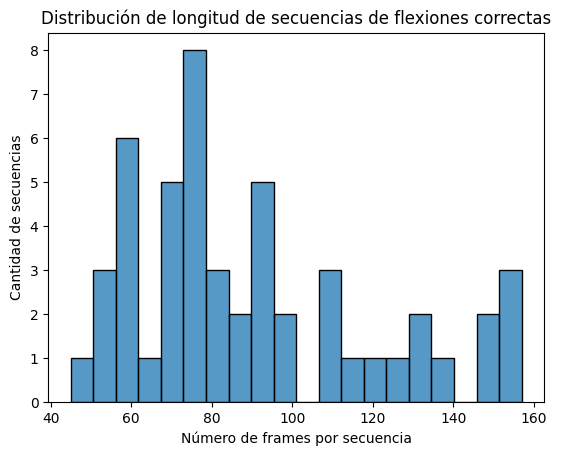

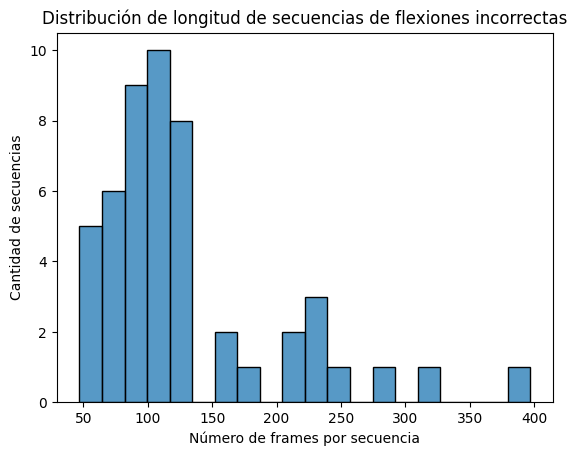

In [ ]:
# Graficamos la distribución de número de frames por secuencia
import matplotlib.pyplot as plt 
import seaborn as sns

sns.histplot([l[0] for l in lengths_correct], bins=20)
plt.xlabel("Número de frames por secuencia")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución de longitud de secuencias de flexiones correctas")
plt.show()

sns.histplot([l[0] for l in lengths_wrong], bins=20)
plt.xlabel("Número de frames por secuencia")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución de longitud de secuencias de flexiones incorrectas")
plt.show()


Podemos observar que la gran mayoría de vídeos no tiene más de 200 frames. Por ende, sería conveniente añadirle un padding de 0s a los que tenga menos frames y truncar aquellos que superen esa cantidad.

In [ ]:
import os
import numpy as np

def load_landmark_sequences_from_folder(folder_path, padding_length=200):
    """
    Procesa todos los videos de una carpeta y devuelve un array
    de secuencias de landmarks con shape (n_videos, padding_length, 66).

    Args:
        folder_path (str): ruta a la carpeta con vídeos
        padding_length (int): nº máximo de frames para pad/recorte

    Returns:
        np.ndarray: array final con shape (n_videos, padding_length, 66)
    """

    videos = os.listdir(folder_path)
    sequences = []

    for video_name in videos:
        video_path = os.path.join(folder_path, video_name)

        # Extraemos coordenadas (num_frames, 33, 2)
        seq = extract_xy_sequence(video_path)

        # Aplanamos por frame → (num_frames, 66)
        seq = seq.reshape(seq.shape[0], -1)

        # === Padding o recorte ===
        n_frames = seq.shape[0]

        if n_frames < padding_length:
            # Padding con ceros
            padding_needed = padding_length - n_frames
            padding = np.zeros((padding_needed, 66))
            seq_padded = np.vstack((seq, padding))

        elif n_frames > padding_length:
            # Recorte
            seq_padded = seq[:padding_length, :]

        else:
            seq_padded = seq

        # Añadimos al dataset
        sequences.append(seq_padded)

    # Convertimos lista → numpy array 3D
    return np.array(sequences)


In [ ]:
# Procesamos todos los landmarks de los vídeos de flexiones en ambas carpetas
PADDING_LENGTH = 160  # longitud máxima de secuencia (frames)

correct_push_ups_data = load_landmark_sequences_from_folder(correct_push_ups_path, padding_length=PADDING_LENGTH)
wrong_push_ups_data   = load_landmark_sequences_from_folder(wrong_push_ups_path,   padding_length=PADDING_LENGTH)


print("Forma de los landmarks arrays de los vídeos de flexiones correctas:", correct_push_ups_data.shape)  # (n_videos, 200, 66)
print("Forma de los landmarks arrays de los vídeos de flexiones incorrectas:", wrong_push_ups_data.shape)  # (n_videos, 200, 66)


Forma de los landmarks arrays de los vídeos de flexiones correctas: (50, 200, 66)
Forma de los landmarks arrays de los vídeos de flexiones incorrectas: (50, 200, 66)


In [ ]:
# Almacenamos en discos los arrays procesados
np.save("../data/processed/correct_push_ups_landmarks.npy", correct_push_ups_data)
np.save("../data/processed/wrong_push_ups_landmarks.npy",   wrong_push_ups_data)

## Análisis exploratorio de datos

In [40]:
import numpy as np 
import os

# Indicamos la ruta a los datos
PATH = "../data/processed"

# Cargamos los datos
# Contienen etiquetas con los puntos clave del cuerpo durante las flexiones
# Los arrays tienen forma (num_ejemplos, num_frames, num_keypoints)
# num_keypoints -> 1er_punto_clave_x, 1er_punto_clave_y, 2º_punto_clave_x, 2º_punto_clave_y, ...

correct_push_ups = np.load(os.path.join(PATH, 'correct_push_ups_landmarks.npy'))
wrong_push_ups = np.load(os.path.join(PATH, 'wrong_push_ups_landmarks.npy'))

print("Correct push-ups shape:", correct_push_ups.shape)
print("Incorrect push-ups shape:", wrong_push_ups.shape)

Correct push-ups shape: (50, 160, 66)
Incorrect push-ups shape: (50, 160, 66)


Vemos que ambos conjuntos de datos tienen el mismo número de videos, cada vídeo tiene el mismo número de frames y cada frame tiene el mismo número de landmarks.

**¿Cuál es el rango de valores que toman las coordenadas?**

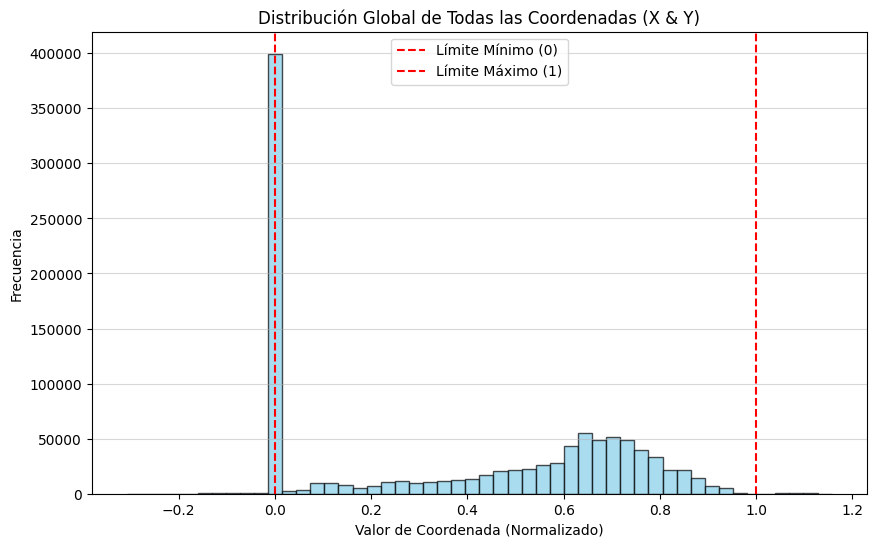

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que 'data_array' es un numpy array de forma (50, 160, 66)
# data_array = np.load('tu_archivo.npy') 

# 1. Aplana todos los datos de coordenadas
all_coords = np.concatenate((correct_push_ups, wrong_push_ups)).flatten()

# 2. Configura y graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(all_coords, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Distribución Global de Todas las Coordenadas (X & Y)')
plt.xlabel('Valor de Coordenada (Normalizado)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)
plt.axvline(x=0, color='r', linestyle='--', label='Límite Mínimo (0)')
plt.axvline(x=1, color='r', linestyle='--', label='Límite Máximo (1)')
plt.legend()
plt.show()

La herramienta de visión artificial MediaPipe Pose predice la posición de 33 puntos clave del cuerpo (x, y), tomando como origen la esquina inferior izquierda del frame. Cada vídeo tenía una longitud distinta originalmente. Sin embargo, anteriormente añadimos paddings de 0s para que todas las secuencias tuvieran la misma longitud, lo que explica la gran cantidad de ceros observada en el histograma. En la arquitectura de red indicaremos que estos 0s son de padding con una capa Masking.

Por otro lado, algunos valores de las coordenadas superan 1 o son menores a 0. Esto ocurre cuando ciertos puntos clave quedan fuera del plano de la imagen. Estos datos pueden considerarse válidos, ya que únicamente representan posiciones fuera del marco visual y, siempre que mantengan coherencia geográfica con el resto del cuerpo, no deberían afectar negativamente al modelo de clasificación.




**¿Cuál es la proporción de relleno (padding) en cada vídeo?**

Veámos la distribución de esta medida en el dataset.

In [42]:
video0 = correct_push_ups[0]  # primer vídeo
#print(video0.shape)  # (160, 66)
#print(video0)        # imprime todos los frames y landmarks del vídeo 0, cada fila indica los landmarks de un frame 

frame0_video0 = correct_push_ups[0, 0]  # primer frame del primer vídeo
#print(frame0_video0.shape)  # (66,)
#print(frame0_video0)        # imprime los 66 landmarks de ese frame (coincide con la primera fila del print anterior)

landmark0_frame0_video0 = correct_push_ups[0, 0, 0]  # primer landmark
#print(landmark0_frame0_video0)  # valor del landmark 

Media de padding por secuencia: 37.63%
Máximo padding: 71.88%
Mínimo padding: 0.00%


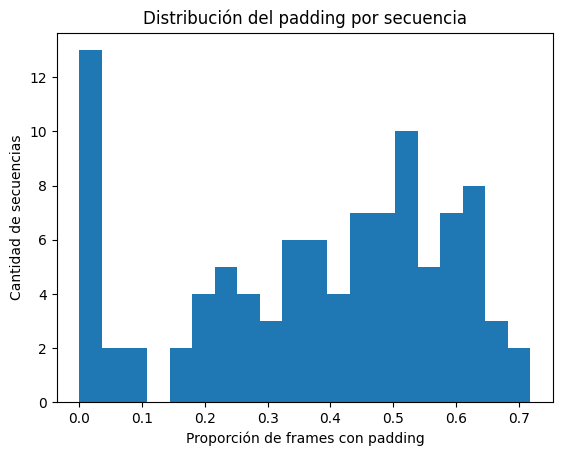

In [43]:
# Calculamos la proporción de frames vacíos (rellenos con ceros) por secuencia
padding_ratios = []

data = np.vstack((correct_push_ups, wrong_push_ups))
for seq in data:
    # Un frame está vacío si todos sus landmarks son 0 
    empty_frames = np.sum(np.all(seq == 0, axis=1)) # suma cada fila que es todo 0
    ratio = empty_frames / seq.shape[0]
    padding_ratios.append(ratio)

# Estadísticas del padding
print(f"Media de padding por secuencia: {np.mean(padding_ratios):.2%}")
print(f"Máximo padding: {np.max(padding_ratios):.2%}")
print(f"Mínimo padding: {np.min(padding_ratios):.2%}")

# Distribución visual
plt.hist(padding_ratios, bins=20)
plt.xlabel("Proporción de frames con padding")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución del padding por secuencia")
plt.show()

El porcentaje obtenido es un poco alto, 37.63% pero esto se debe a que en los videos incorrectos, algunos (9 videos) superaban los 200 frames, llegando hasta los 400, por lo que esto incrementó el numero óptimo de frames por vídeo al calcular $L_{opt}$.

Vamos a comprobar si los landmarks están normalizados

In [44]:
longitudes_combinadas = np.vstack((correct_push_ups, wrong_push_ups)).reshape(-1, correct_push_ups.shape[2]) 
# Con el -1 del reshape combinamos el número de videos y el número de frames, obteniendo una lista donde cada fila es un frame individual de cualquier video (100*160 numero de filas).
# 'correct_push_ups.shape[2]' lo que hace es mantener el número de landmarks (66) como el número de columnas, es decir, cada fila tiene los 66 landmarks de ese frame.

min_val = np.min(longitudes_combinadas)
max_val = np.max(longitudes_combinadas)

print(f"Valor mínimo de coordenadas: {min_val:.4f}")
print(f"Valor máximo de coordenadas: {max_val:.4f}")

Valor mínimo de coordenadas: -0.3072
Valor máximo de coordenadas: 1.1568


Vamos a normalizar los landmarks.

In [45]:
rango = max_val - min_val

# Aplicamos la fórmula de Re-normalización
longitudes_combinadas_escaladas = (longitudes_combinadas - min_val) / rango

correct_push_ups_escaladas = (correct_push_ups - min_val) / rango
incorrect_push_ups_escaladas = (wrong_push_ups - min_val) / rango

Podemos ver que en el caso de los vídeos correctos (los únicos que hemos seleccionado), los landmarks se agrupan por zonas más o menos diferenciadas, lo cual es indicativo de que los landmarks están ordenados. Es un poco complicado diferenciar las partes del cuerpo, por lo que vamos a ver la distribución espacial de los landmarks uniendo los puntos para poder visualizar la pose promedio de cada clase.

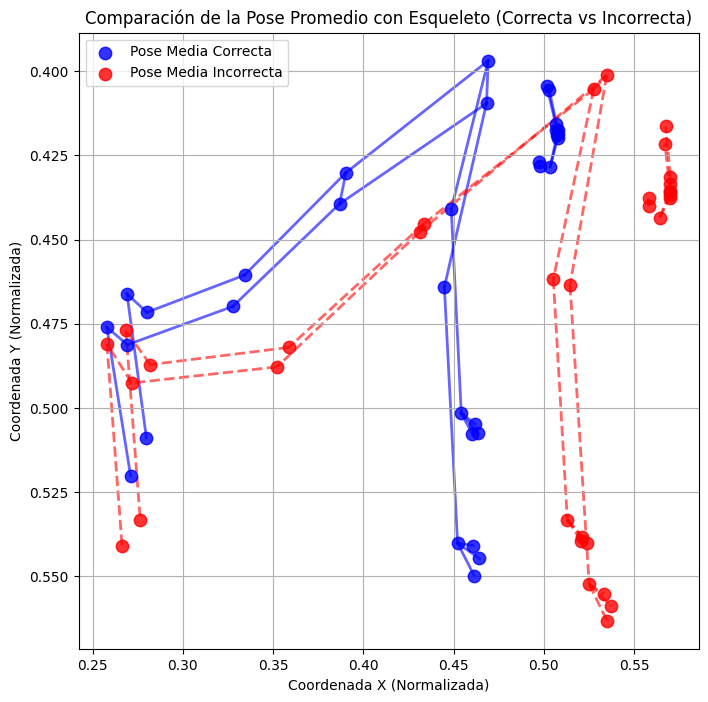

In [47]:
# Definimos las conexiones del esqueleto (pares de índices de landmarks) 
# Esto es específico para un modelo de 33 landmarks (como MediaPipe Pose), cada tupla (start_idx, end_idx) conecta dos landmarks.
# Si buscamos información sobre las conexiones de MediaPipe Pose: https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=es-419#models, vemos que cada punto corresponde a la siguiente parte del cuerpo:
CONNECTIONS = [
    # Cabeza
    (0, 1), (1, 2), (2, 3), (3, 7), 
    (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), 

    # Torso y Hombros
    (11, 12),  # Hombros
    (11, 23),  # Hombro Izquierdo a Cadera Izquierda
    (12, 24),  # Hombro Derecho a Cadera Derecha
    (23, 24),  # Caderas

    # Brazo Izquierdo
    (11, 13), (13, 15), 
    # Mano Izquierda
    (15, 17), (15, 19), (15, 21), 

    # Brazo Derecho
    (12, 14), (14, 16), 
    # Mano Derecha
    (16, 18), (16, 20), (16, 22), 

    # Pierna Izquierda
    (23, 25), (25, 27), 
    # Pie Izquierdo
    (27, 29), (29, 31), 

    # Pierna Derecha
    (24, 26), (26, 28), 
    # Pie Derecho
    (28, 30), (30, 32) 
]

# Preparación y cálculo de la media (versiones escaladas)
data_correctas = correct_push_ups_escaladas
data_incorrectas = incorrect_push_ups_escaladas

# Aplanamos los datos para obtener todos los frames juntos 
frames_correctos_aplanados = data_correctas.reshape(-1, data_correctas.shape[-1]) # (50*160, 66) 
frames_incorrectos_aplanados = data_incorrectas.reshape(-1, data_incorrectas.shape[-1]) # (50*160, 66)

# Calculamos el promedio de cada columna (landmark) a lo largo de todos los frames de cada clase (la pose promedio de cada clase) y dividimos el vector de 66 valores en pares (X, Y) 
pose_media_correcta = np.mean(frames_correctos_aplanados, axis=0).reshape(-1, 2) # tiene la forma [[X0, Y0], [X1, Y1], ..., [X32, Y32]]^T
pose_media_incorrecta = np.mean(frames_incorrectos_aplanados, axis=0).reshape(-1, 2)


# Gráfico de comparación con conexiones 
plt.figure(figsize=(8, 8))
plt.title('Comparación de la Pose Promedio con Esqueleto (Correcta vs Incorrecta)')
plt.xlabel('Coordenada X (Normalizada)')
plt.ylabel('Coordenada Y (Normalizada)')
plt.gca().invert_yaxis() # Y==0 es la parte superior

# Dibujamos la pose promedio correcta (Azul)
plt.scatter(pose_media_correcta[:, 0], pose_media_correcta[:, 1], 
            label='Pose Media Correcta', 
            color='blue', 
            alpha=0.8, s=80, zorder=2)
# Conectamos los puntos correctos
for connection in CONNECTIONS:
    start_point = pose_media_correcta[connection[0]]
    end_point = pose_media_correcta[connection[1]]
    plt.plot([start_point[0], end_point[0]], 
             [start_point[1], end_point[1]], 
             color='blue', linestyle='-', linewidth=2, alpha=0.6, zorder=1)


# Dibujamos la pose promedio incorrecta (Rojo)
plt.scatter(pose_media_incorrecta[:, 0], pose_media_incorrecta[:, 1], 
            label='Pose Media Incorrecta', 
            color='red', alpha=0.8, s=80, zorder=2)
# Conectamos los puntos incorrectos
for connection in CONNECTIONS:
    start_point = pose_media_incorrecta[connection[0]]
    end_point = pose_media_incorrecta[connection[1]]
    plt.plot([start_point[0], end_point[0]], 
             [start_point[1], end_point[1]], 
             color='red', linestyle='--', linewidth=2, alpha=0.6, zorder=1) # Líneas discontinuas para diferenciar

plt.legend()
plt.grid(True)
plt.show()

Se aprecian perfectamente las partes del cuerpo en ambas clases y se ve cómo en la clase de flexiones incorrectas, las rodillas y la cabeza están más abajo de lo normal.


### Estadísticas descriptivas

Media, desviación estándar y rango por landmark (x, y).

Comparación entre clases: ¿la media de la posición del pecho o codo difiere entre clases?

In [48]:
# Definimos los nombres de los landmarks 
LANDMARK_NAMES = [
    'nose', 'left eye (inner)', 'left eye', 'left eye (outer)', 'right eye (inner)', 'right eye', 'right eye (outer)', 
    'left ear', 'right ear', 'mouth (left)', 'mouth (right)', 'left shoulder', 'right shoulder', 'left elbow', 
    'right elbow', 'left wrist', 'right wrist', 'left pinky', 'right pinky', 'left index', 'right index', 
    'left thumb', 'right thumb', 'left hip', 'right hip', 'left knee', 'right knee', 'left ankle', 
    'right ankle', 'left heel', 'right heel', 'left foot index', 'right foot index'
]

# Creamos una lista de 66 nombres: 'nose (X)', 'nose (Y)', 'left eye (inner) (X)', 'left eye (inner) (Y)', ...
COORD_NAMES = [f'{name} ({coord})' for name in LANDMARK_NAMES for coord in ['X', 'Y']]
NUM_COORDS = len(COORD_NAMES) # 66

# Combinamos y aplanamos los datos escalados para que cada fila sea un frame único.
frames_correctos_aplanados = correct_push_ups_escaladas.reshape(-1, NUM_COORDS) # (num_frames_correctos, 66)
frames_incorrectos_aplanados = incorrect_push_ups_escaladas.reshape(-1, NUM_COORDS)

# Combinamos todos los frames en un solo array grande para el cálculo global.
longitudes_combinadas_escaladas = np.vstack((frames_correctos_aplanados, frames_incorrectos_aplanados)) # (16000, 66)

# Calculamos las estadísticas a lo largo del eje 0 (todos los frames)
media = np.mean(longitudes_combinadas_escaladas, axis=0)
desviacion_estandar = np.std(longitudes_combinadas_escaladas, axis=0)
maximo = np.max(longitudes_combinadas_escaladas, axis=0)
minimo = np.min(longitudes_combinadas_escaladas, axis=0)
rango = maximo - minimo

# Visualización del DataFrame de resultados 
df_resultados = pd.DataFrame({
    'Coordenada': COORD_NAMES,
    'Media (μ)': media,
    'Desviación Estándar (σ)': desviacion_estandar,
    'Máximo': maximo,
    'Mínimo': minimo,
    'Rango (Max - Min)': rango
})

# Mostramos los resultados
print("Estadísticas Descriptivas por Landmark:\n")
print(df_resultados.to_markdown(index=False, numalign="left", stralign="left")) # Hacemos que la tabla se vea bien en la terminal

Estadísticas Descriptivas por Landmark:

| Coordenada            | Media (μ)   | Desviación Estándar (σ)   | Máximo   | Mínimo      | Rango (Max - Min)   |
|:----------------------|:------------|:--------------------------|:---------|:------------|:--------------------|
| nose (X)              | 0.533876    | 0.254648                  | 0.865437 | 0.209855    | 0.655581            |
| nose (Y)              | 0.435909    | 0.194246                  | 0.841001 | 0.209855    | 0.631146            |
| left eye (inner) (X)  | 0.538809    | 0.258286                  | 0.867372 | 0.209855    | 0.657516            |
| left eye (inner) (Y)  | 0.428653    | 0.189651                  | 0.839148 | 0.209855    | 0.629292            |
| left eye (X)          | 0.538814    | 0.258267                  | 0.866664 | 0.209855    | 0.656808            |
| left eye (Y)          | 0.427639    | 0.188872                  | 0.837506 | 0.209855    | 0.62765             |
| left eye (outer) (X)  | 0.53881     |

Con estos resultados podemos ver la ubicación media de diversas partes del cuerpo, por ejemplo la nariz está a una altura de 0.533876 del eje X, mientras que el pie derecho está a una altura de 0.268688 respecto al eje X. Las desviaciones nos sirven para ver cuanto varía la posición del landmark respecto a su media, y como podemos observar, obtenemos valores normales teniendo en cuenta que el movimiento es una flexión. Si nos vamos a partes más fijas a lo largo de una flexión, como pueden ser los pies que permanecen inmóviles, obtenemos desviaciones mucho más bajas en el eje X, como 0.0780976 en el pie izquierdo y 0.0738948 en el derecho.

### Ángulos que forman los landmarks
Unas características muy importante a la hora de determinar si una flexión se realiza correctamente son los ángulos articulares (por ejemplo, doblar las rodillas es síntoma de que la técnica no es buena).

In [49]:
import math

# Definición de índices de MediaPipe Pose
KEYPOINTS = {
    'Hombro_I': 11, 'Hombro_D': 12,
    'Codo_I': 13,   'Codo_D': 14,
    'Muñeca_I': 15, 'Muñeca_D': 16,
    'Cadera_I': 23, 'Cadera_D': 24,
    'Rodilla_I': 25, 'Rodilla_D': 26,
    'Tobillo_I': 27, 'Tobillo_D': 28
}

def calculate_angle(p1, p2_vertex, p3):
    """
    Calcula el ángulo en grados formado por tres puntos (p1-p2_vertex-p3).
    p2_vertex es el punto donde se forma el ángulo (el vértice).
    
    Args:
        p1 (np.array): Coordenadas (x, y) del primer punto (A).
        p2_vertex (np.array): Coordenadas (x, y) del vértice (B).
        p3 (np.array): Coordenadas (x, y) del tercer punto (C).
        
    Returns:
        float: El ángulo en grados, o 0.0 si hay un error (ej. punto faltante).
    """
    # 1. Calcular los vectores
    vector_ba = p1 - p2_vertex  # A - B
    vector_bc = p3 - p2_vertex  # C - B
    
    # 2. Calcular producto punto y magnitudes
    dot_product = np.dot(vector_ba, vector_bc)
    norm_ba = np.linalg.norm(vector_ba)
    norm_bc = np.linalg.norm(vector_bc)
    
    # Manejar el caso de vectores de longitud cero
    if norm_ba == 0 or norm_bc == 0:
        return 0.0
    
    # 3. Aplicar la fórmula del coseno
    cosine_theta = dot_product / (norm_ba * norm_bc)
    
    # 4. Asegurar el rango y calcular el ángulo
    # np.clip se usa para manejar pequeños errores de coma flotante que
    # pueden causar que el valor exceda [-1, 1].
    cosine_theta = np.clip(cosine_theta, -1.0, 1.0)
    
    angle_rad = math.acos(cosine_theta)
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg
def get_key_joint_angles(landmarks):
    """
    Calcula los ángulos articulares clave para flexiones y sentadillas.

    Args:
        landmarks: El objeto de landmarks de MediaPipe (asumiendo que tiene
                   una lista de objetos con atributos .x y .y). 
                   Si es un array numpy simple, el acceso deberá ajustarse.

    Returns:
        dict: Un diccionario con los nombres de los ángulos y sus valores en grados.
    """
    
    angles = {}
    
    # Función de ayuda para extraer las coordenadas (x, y)
    def get_coords(idx):
        x_pos = idx * 2
        y_pos = idx * 2 + 1
        # Usamos :2 por si se incluye una tercera coordenada (z o visibilidad)
        return landmarks[x_pos:y_pos+1]

    # --- 1. Ángulos para Flexiones (Push-ups) ---

    # Codo Izquierdo (Hombro I - Codo I - Muñeca I)
    angles['Codo_I'] = calculate_angle(
        get_coords(KEYPOINTS['Hombro_I']), get_coords(KEYPOINTS['Codo_I']), get_coords(KEYPOINTS['Muñeca_I'])
    )
    
    # Codo Derecho (Hombro D - Codo D - Muñeca D)
    angles['Codo_D'] = calculate_angle(
        get_coords(KEYPOINTS['Hombro_D']), get_coords(KEYPOINTS['Codo_D']), get_coords(KEYPOINTS['Muñeca_D'])
    )
    
    # Cadera Izquierda (Hombro I - Cadera I - Rodilla I) - Para alineación de tronco
    angles['Cadera_I_Tronco'] = calculate_angle(
        get_coords(KEYPOINTS['Hombro_I']), get_coords(KEYPOINTS['Cadera_I']), get_coords(KEYPOINTS['Rodilla_I'])
    )
    
    # Cadera Derecha (Hombro D - Cadera D - Rodilla D) - Para alineación de tronco
    angles['Cadera_D_Tronco'] = calculate_angle(
        get_coords(KEYPOINTS['Hombro_D']), get_coords(KEYPOINTS['Cadera_D']), get_coords(KEYPOINTS['Rodilla_D'])
    )

    # --- 2. Ángulos para Sentadillas (Squats) ---
    
    # Rodilla Izquierda (Cadera I - Rodilla I - Tobillo I)
    angles['Rodilla_I'] = calculate_angle(
        get_coords(KEYPOINTS['Cadera_I']), get_coords(KEYPOINTS['Rodilla_I']), get_coords(KEYPOINTS['Tobillo_I'])
    )
    
    # Rodilla Derecha (Cadera D - Rodilla D - Tobillo D)
    angles['Rodilla_D'] = calculate_angle(
        get_coords(KEYPOINTS['Cadera_D']), get_coords(KEYPOINTS['Rodilla_D']), get_coords(KEYPOINTS['Tobillo_D'])
    )
    
    # Cadera Izquierda (Hombro I - Cadera I - Rodilla I) - Para flexión de cadera
    # Es el mismo cálculo que el de alineación, pero con un propósito diferente en el squat
    angles['Cadera_I_Squat'] = calculate_angle(
        get_coords(KEYPOINTS['Hombro_I']), get_coords(KEYPOINTS['Cadera_I']), get_coords(KEYPOINTS['Rodilla_I'])
    )

    # Cadera Derecha (Hombro D - Cadera D - Rodilla D) - Para flexión de cadera
    angles['Cadera_D_Squat'] = calculate_angle(
        get_coords(KEYPOINTS['Hombro_D']), get_coords(KEYPOINTS['Cadera_D']), get_coords(KEYPOINTS['Rodilla_D'])
    )

    return angles

### Ejemplo
# Use the actual landmark vector for frame 30 of video 0 (not its shape)
frame_example = correct_push_ups[0][30]
# Ensure it's a numpy array so vector operations work
frame_example = np.asarray(frame_example)
get_key_joint_angles(frame_example)


{'Codo_I': 140.07000976460125,
 'Codo_D': 118.80334800314809,
 'Cadera_I_Tronco': 165.44894378152694,
 'Cadera_D_Tronco': 157.27899893776717,
 'Rodilla_I': 152.4667890369443,
 'Rodilla_D': 140.88231085101697,
 'Cadera_I_Squat': 165.44894378152694,
 'Cadera_D_Squat': 157.27899893776717}

In [50]:
import numpy as np
import pandas as pd

def transform_landmarks_to_angles(landmarks):
    """
    landmarks: numpy array con forma (n_ejemplos, n_frames, 66)
    
    Devuelve:
        angles_df: DataFrame de forma (n_frames_totales, 8)
    """

    # 1. Aplanar -> (n_total_frames, 66)
    landmarks_flatten = landmarks.reshape(-1, 66)

    # Lista donde guardaremos los diccionarios de cada frame
    all_angles = []

    # 2. Procesar frame por frame
    for frame_landmarks in landmarks_flatten:
        if not np.all(frame_landmarks == 0):

            # Aplicamos la función que ya tienes implementada
            angles_dict = get_key_joint_angles(frame_landmarks)

            # Guardamos el resultado
            all_angles.append(angles_dict)

    # 3. Convertimos a DataFrame
    angles_df = pd.DataFrame(all_angles)

    return angles_df

angles_correct_push_ups = transform_landmarks_to_angles(correct_push_ups)
angles_wrong_push_ups = transform_landmarks_to_angles(wrong_push_ups)




In [59]:
# 1. Etiquetamos y combinamos los DataFrames
angles_correct_push_ups['Clase'] = 'Correcto'
angles_wrong_push_ups['Clase'] = 'Incorrecto'

# Concatenar en un único DataFrame grande
df_combined = pd.concat([angles_correct_push_ups, angles_wrong_push_ups], ignore_index=True)
df_combined.head()

,Codo_I,Codo_D,Cadera_I_Tronco,Cadera_D_Tronco,Rodilla_I,Rodilla_D,Cadera_I_Squat,Cadera_D_Squat,Clase
0,170.071473,158.575976,171.785524,172.048164,160.684274,152.837166,171.785524,172.048164,Correcto
1,167.516422,158.066393,174.729168,173.036461,162.011170,152.188698,174.729168,173.036461,Correcto
2,166.187046,154.504825,178.359986,174.338558,165.998701,152.697205,178.359986,174.338558,Correcto
3,162.907825,149.694590,179.714923,173.404061,167.727411,152.533876,179.714923,173.404061,Correcto
4,159.276850,143.856148,179.436415,171.370845,167.173054,152.992387,179.436415,171.370845,Correcto


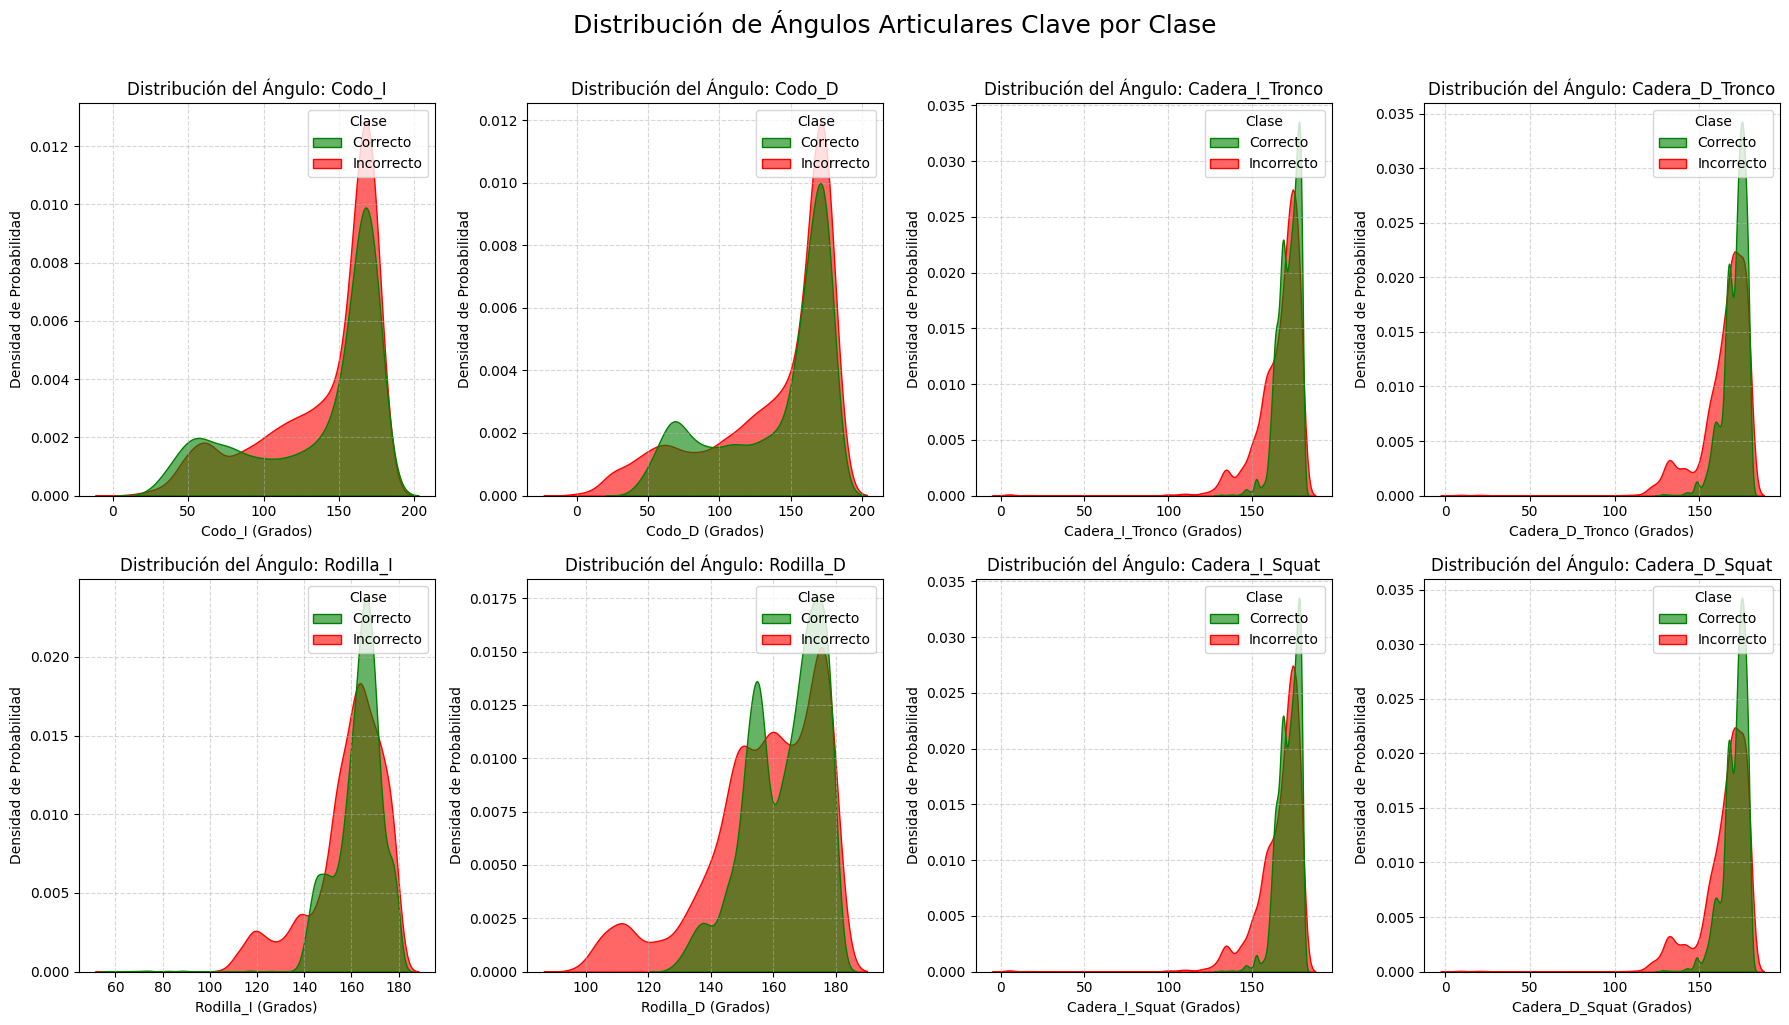

In [ ]:

# Definimos los ángulos que queremos graficar (todos los 8)
all_angle_columns = df_combined.columns[:-1] # Excluye la columna 'Clase'
num_plots = len(all_angle_columns)

# Configuramos el lienzo (ejemplo con 4 columnas)
fig, axes = plt.subplots(
    nrows=int(np.ceil(num_plots / 4)), 
    ncols=min(num_plots, 4), 
    figsize=(18, 5 * int(np.ceil(num_plots / 4)))
)
# Aplanamos los ejes
axes = axes.flatten() 

# Título general
fig.suptitle('Distribución de Ángulos Articulares Clave por Clase', 
             fontsize=18, 
             y=1.02)

# Bucle para generar los gráficos
for i, angle_col in enumerate(all_angle_columns):
    
    # Usamos seaborn.kdeplot para comparar las distribuciones
    sns.kdeplot(
        data=df_combined,
        x=angle_col,
        hue='Clase',        # Diferencia las clases por color
        fill=True,          # Rellena el área bajo la curva
        palette={'Correcto': 'green', 'Incorrecto': 'red'},
        alpha=0.6,
        ax=axes[i]
    )
    
    axes[i].set_title(f'Distribución del Ángulo: {angle_col}')
    axes[i].set_xlabel(f'{angle_col} (Grados)')
    axes[i].set_ylabel('Densidad de Probabilidad')
    axes[i].grid(True, linestyle='--', alpha=0.5)


plt.tight_layout(rect=[0, 0, 1, 1.01]) # Ajustar el diseño para evitar solapamientos
plt.show()

Parece que las distribuciones de los ángulos articulares de cada clase son muy similares. Si nos fijamos en las distribuciones de los ángulos de las rodillas, por debajo de 150º encontramos más frames de posturas incorrectas que correctas (cuanto menor sea el ángulo más se dobla la articulación).

### Reducción de dimensionalidad

Aplicamos PCA o t-SNE sobre los vectores medios de cada vídeo → ver si las clases se separan visualmente.

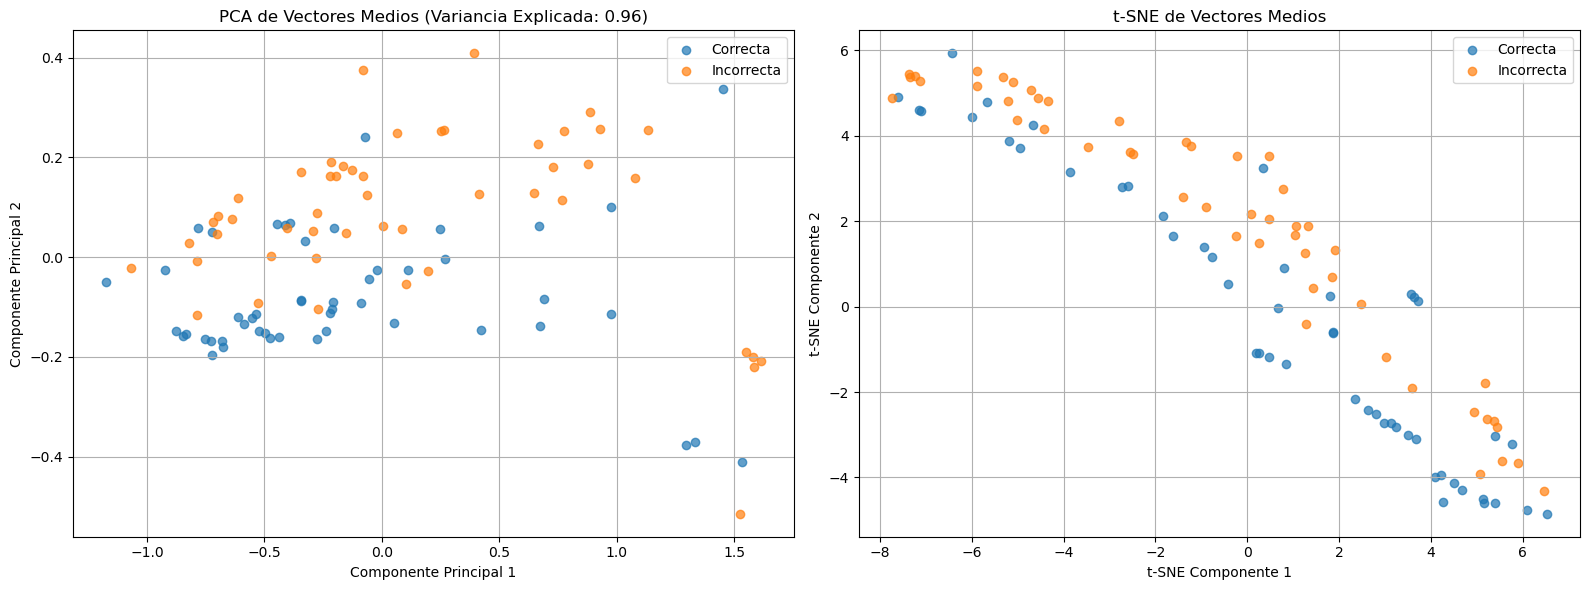

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Calculamos el vector medio (pose promedio) por vídeo 
mean_vectors_correct = np.mean(correct_push_ups_escaladas, axis=1) # Media a lo largo del eje 1 (frames). Esto reduce la forma (Videos, Frames, Coordenadas) a (Videos, Coordenadas)
mean_vectors_incorrect = np.mean(incorrect_push_ups_escaladas, axis=1)

# Combinamos los vectores medios en una sola matriz (X_mean) y creamos etiquetas (y)
X_mean = np.vstack((mean_vectors_correct, mean_vectors_incorrect))
y = np.array(['Correcta'] * mean_vectors_correct.shape[0] + ['Incorrecta'] * mean_vectors_incorrect.shape[0])

# Aplicamos PCA 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_mean)
explained_variance = pca.explained_variance_ratio_.sum()

# Aplicamos t-SNE 
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto') 
X_tsne = tsne.fit_transform(X_mean)

# Generamos gráficos
plt.figure(figsize=(16, 6))

# Subplot 1: PCA
plt.subplot(1, 2, 1)
for label in np.unique(y):
    subset = X_pca[y == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=label, alpha=0.7)

plt.title(f'PCA de Vectores Medios (Variancia Explicada: {explained_variance:.2f})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)

# Subplot 2: t-SNE
plt.subplot(1, 2, 2)
for label in np.unique(y):
    subset = X_tsne[y == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=label, alpha=0.7)

plt.title('t-SNE de Vectores Medios')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('visualizacion_separacion_clases.png')
plt.show()

En el PCA, a pesar de que ambos conjuntos no estén completamente separados (se mezclan en el centro) podemos ver cómo los puntos naranjas (flexiones incorrectas) se agrupan en la parte superior derecha (valores más altos), mientras que los puntos que hacen referencia a las flexiones bien hechas, se agrupan en la parte media-inferior izquierda (valores más bajos) 

El gráfico de t-SNE confirma la separación encontrada por PCA. t-SNE muestra una clara estructura lineal donde los puntos de una clase siguen una línea que está por encima o por debajo de los puntos de la otra clase, con una separación mínima. La mayoría de los puntos incorrectos (naranja) están desplazados ligeramente por encima y a la izquierda de los puntos correctos (azul). Esto sugiere que la diferencia entre las clases es ciertamente consistente.  
Concluyendo, mediante t-SNE observamos que en el espacio de alta dimensión (los 66 landmarks), los videos de una clase están íntimamente relacionados entre sí, y que la distancia entre un video correcto y un video incorrecto es grande.